In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None #does nothing by default
        self._prev = set(_children) #saves a set of the children, basically what inputs were needed for the output
        self._op = _op #helper, allows to easily see how the output was obtained
        self.label = label #name for each node

    def __repr__(self): #nice printout of the data
        return f"Value(data={self.data})"

    def __add__(self, other): #adding operation implemented for Value class
        other = other if isinstance(other, Value) else Value(other) #checks that the 'other' is from Value class to save it as a child
        out = Value(self.data + other.data, (self, other), '+') #creates output Value
        def _backward(): # method used to get gradient values of nodes
            self.grad += 1.0 * out.grad #derivative/gradient of addition
            other.grad += 1.0 * out.grad
        out._backward = _backward #method so it does above thing when called
        return out

    def __neg__(self): #-self
        return self * -1

    def __sub__(self, other):#1-self
        return self + (-other)

    def __rsub__(self,other):#fallback for subtraction
        return self - other

    def __radd__(self,other): #fallback for addition
        return self + other

    def __mul__(self, other): #self+other
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out

    def __pow__(self, other):#self**other
        assert isinstance(other, (int, float))
        out = Value(self.data ** other, (self, ), f'**{other}') #other won't be saves as child, this is just the exponent
        def _backward():
            self.grad += (other * self.data**(other-1)) * (out.grad)
        out._backward = _backward
        return out

    def __rmul__(self, other): #fallback for mult
        return self * other

    def __truediv__(self, other): #self*other**-1
        return self * other**-1

    def __rtruediv__(self, other): #fallback
        return self * other**-1

    def tanh(self): #self.tanh()
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) #tanh
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out

    def exp(self):#e**self
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad       
        out._backward = _backward
        return out

    def backward(self): #this is to call _backward on every node in order from output to children
        topo = []
        visited = set()
        def build_topo(v): #method to get order from children to parent nodes
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo): #will go through parent and its children first, then next parent and its children. 
            node._backward() #calls the _backward method of each 'Value'

In [3]:
from graphviz import Digraph

def trace(root):
    #builds a set of all nodes and edged in a graph
    nodes , edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) #LR left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        #for any value in the graph create a rectangular 'record' node for it.
        dot.node(name = uid, label = "{ %s | data %.4f | %.4f}" % (n.label, n.data, n.grad, ), shape='record')
        if n._op:
            #if this value is the result of any operation create a node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        #c onnect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

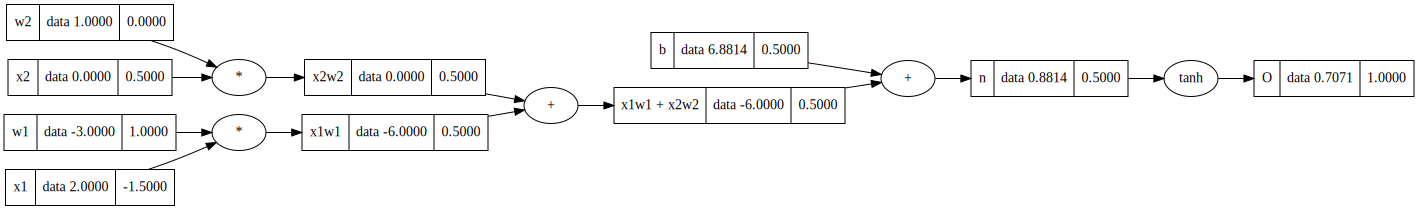

In [4]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weight w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of neuron b
b = Value(6.8813735870195432, label = 'b')
#x1*w1 + x2*w2 + b, individual steps so we have pointers for backpropagation
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'O'
o.backward()
draw_dot(o)

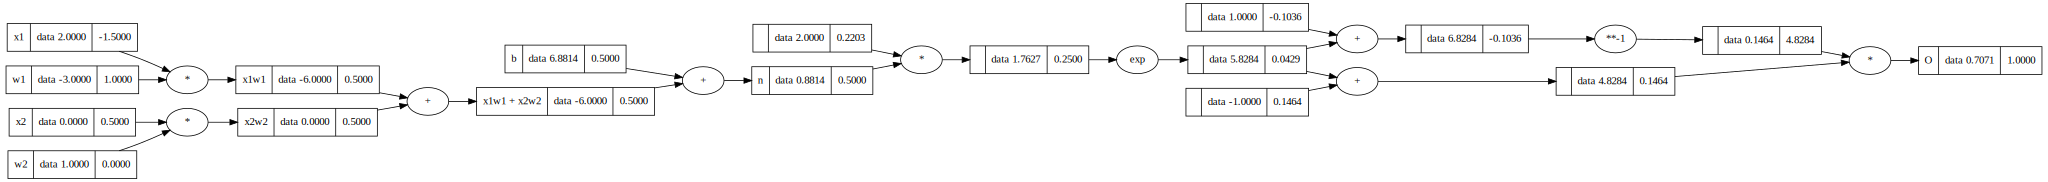

In [5]:
#inputs x1,x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
#weight w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
#bias of neuron b
b = Value(6.8813735870195432, label = 'b')
#x1*w1 + x2*w2 + b, individual steps so we have pointers for backpropagation
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#-----
e = (2*n).exp()
o = (e - 1) / (e + 1)
o.label = 'O'
#-----
o.backward()
draw_dot(o)

In [6]:
import torch

In [7]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('w2', w2.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('x1', x1.grad.item())

0.7071066904050358
---
w2 0.0
x2 0.5000001283844369
w1 1.0000002567688737
x1 -1.5000003851533106


In [8]:
class Neuron: #creation of single neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #creates list of random weights between -1 and 1
        self.b = Value(random.uniform(-1,1)) #creates random bias

    def __call__(self,x):
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) #basically pairs the values on the tuples 'w' and 'x'
        out = act.tanh() #we squash the activation value
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer: #creation of single layer
    def __init__(self, nin, nout): #we take the dimension of the neurons and how many do we want
        self.neurons = [Neuron(nin) for _ in range(nout)] #we make the list of neurons based on the number of out we wanted

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] #calls for neuron creation based on the list of neurons
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        params = []
        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self, nin, nouts): #instead of getting the number for a single layer we get a list with the length of every layer
        sz = [nin] + nouts #putting all of them together [1,3,3,1] can be the neural network
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #makes list for layer of 1 input and 3 output, then 3 input 3 output, etc...

    def __call__(self, x):
        for layer in self.layers: #calls for layer creation based on self.layers list
            x = layer(x)
        return x
    def parameters(self):
        params = []
        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)
        return params

In [9]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1]) #layered as 3,4,4,1
n(x)

Value(data=-0.45444955044967256)

In [10]:
xs = [
    [2.0,3.0,-1.0], #feature values
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0] #all of them go through their own 'neural network'
]
ys = [1.0, -1.0, -1.0, 1.0] #targets

In [11]:
#Getting the loss of the neural net based on xs and target(ys)
for k in range(1000):

    #forward pass
    ypred = [n(x) for x in xs] #forms the predictions based on the xs
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred)) #sum squared error

    #backward pass
    for p in n.parameters():
        p.grad = 0.0 #common mistake!! don't forget to grad_zero so the grads dont aggregate to each other
    loss.backward() #calls for gradient calculation of each neural network

    #update / Gradient descent
    for p in n.parameters(): #updates the weights and bias of the neural network
        p.data += -0.01*p.grad #step size
    

In [12]:
ypred

[Value(data=0.9763095777739448),
 Value(data=-0.9842425865615991),
 Value(data=-0.967543966641923),
 Value(data=0.966718746219901)]

In [13]:
loss

Value(data=0.0029705681380334326)